https://heartbeat.comet.ml/how-to-build-a-text-classification-model-using-huggingface-transformers-and-comet-4d40236e8f84



In [1]:
import pandas as pd
import numpy as np
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter
import torch

In [2]:
suffix = 'us_region'

In [3]:
torch.cuda.empty_cache()

In [4]:
df = pd.read_csv('tweets_us.csv')
df.info()

/home/srtoner/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,10,11,12,13,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720199 entries, 0 to 720198
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              720199 non-null  object 
 1   tweet_id             720199 non-null  object 
 2   tweet_text           720199 non-null  object 
 3   place_id             700522 non-null  object 
 4   place_name           700509 non-null  object 
 5   full_place_name      700509 non-null  object 
 6   country              700509 non-null  object 
 7   country_code         700509 non-null  object 
 8   place_type           700509 non-null  object 
 9   username             700509 non-null  object 
 10  profile_description  616224 non-null  object 
 11  profile_name         700502 non-null  object 
 12  profile_location     603704 non-null  object 
 13  lat                  700509 non-null  object 
 14  lon                  667729 non-null  float64
 15  clean_text       

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
df = df.dropna(subset = ['region', 'division'])

In [7]:
region_list = list(df.region.unique())
div_list = list(df.division.unique())

In [8]:
df.columns

Index(['user_id', 'tweet_id', 'tweet_text', 'place_id', 'place_name',
       'full_place_name', 'country', 'country_code', 'place_type', 'username',
       'profile_description', 'profile_name', 'profile_location', 'lat', 'lon',
       'clean_text', 'state', 'region', 'division'],
      dtype='object')

In [9]:
filtered_df = df[['user_id', 'tweet_id', 'tweet_text', 'state', 'region', 'division']]
filtered_df.head()
updated_df = filtered_df.astype({'user_id':np.int64, 'tweet_id': np.int64, 'tweet_text': str, 'state':str, 'region':str, 'division':str})
updated_df.to_csv('updated_df.csv')

# Start with Region

id2label = {idx:label for idx, label in enumerate(region_list)}
label2id = {label:idx for idx, label in enumerate(region_list)}

In [10]:
updated_df.shape

(667729, 6)

In [11]:
# sample_df = updated_df.sample(5000, random_state = 1)
sample_df = updated_df.sample(40000, random_state = 1)
sample_df.head()
sample_df['label'] = sample_df['region'].apply(lambda x: label2id[x])
sample_df.head()

,user_id,tweet_id,tweet_text,state,region,division,label
509599,50141097,1634945013657513984,Bud take notes 📝 https://t.co/18UsBMS5dj,CA,West,Pacific,2
361222,139639967,1637257031672549377,@DaggerMcTimbers He was one of the best parts ...,CO,West,Mountain,2
496933,827982437573591040,1633622922882433025,@HoosierMamaTags @MrRaceBannon Watching this o...,TN,South,East South Central,0
610610,1210208851909173248,1630760839128182785,Another thing to put on the calendar https://t...,ID,West,Mountain,2
47287,77109252,1632188955859861511,ATTACK THE RIM!!,MD,South,South Atlantic,0


<AxesSubplot:xlabel='label'>

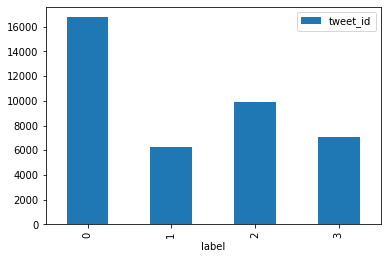

In [12]:
sample_df.groupby('label').agg('count').reset_index().plot(x='label', y = 'tweet_id', kind = 'bar')

In [13]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [14]:
from datasets import Dataset

In [15]:
test_size = 0.2
val_size = 0.2

y = sample_df['label']

X = sample_df

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size,random_state = 630, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,random_state = 630, test_size = val_size / (1 - test_size), stratify = y_train)


In [16]:
# train, validate, test = np.split(sample_df.sample(frac=1), [int(.6*len(sample_df)), int(.8*len(sample_df))])
train, validate, test = X_train, X_val, X_test

In [17]:
train.to_csv('train_us_region.csv', index=False)
test.to_csv('test_us_region.csv', index = False)
validate.to_csv('validate_us_region.csv', index = False)

In [18]:
ds_train = Dataset.from_csv('train_us_region.csv')
ds_val = Dataset.from_csv('validate_us_region.csv')
ds_test = Dataset.from_csv('test_us_region.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-b56fd30f2d167a56/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-36435c40b707d750/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-19487ddda7c85958/0.0.0. Subsequent calls will reuse this data.


In [19]:
ds = {"train": ds_train, "validation": ds_val, "test": ds_test}

In [20]:
ds_train[0]

{'user_id': 2374832251,
 'tweet_id': 1587987931897044992,
 'tweet_text': 'I want a big brown eyed lover to cherish and to hold.',
 'state': 'HI',
 'region': 'West',
 'division': 'Pacific',
 'label': 2}

In [21]:
ds_val

Dataset({
    features: ['user_id', 'tweet_id', 'tweet_text', 'state', 'region', 'division', 'label'],
    num_rows: 8000
})

In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("Twitter/twhin-bert-base", num_labels=len(id2label), id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at Twitter/twhin-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-ba

In [23]:
model = model.to(device)

In [24]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

In [25]:
import re

In [26]:
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Using old preprocessing function for now, baseline results
def preprocess_function(examples):
    label = examples["label"] 
    # examples['tweet_text'].apply(preprocess)
    examples = tokenizer(preprocess(examples["tweet_text"]), truncation=True, padding="max_length", max_length=256, return_tensors='pt')
#     examples = tokenizer(examples["tweet_text"], truncation=True, padding="max_length", max_length=256, return_tensors='pt')
    
    for key in examples:
        examples[key] = examples[key].squeeze(0)#.to(device)
    examples["label"] = torch.IntTensor([label])
    examples = examples.to(device)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=['user_id', 'tweet_id', 'tweet_text', 'state', 'region', 'division', 'label'])
    ds[split].set_format('pt')

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [27]:
example = next(iter(ds['train']))

In [28]:
example

{'label': tensor([2]),
 'input_ids': tensor([     0,     87,   3444,     10,   6957, 119455,  36298,     71, 100306,
             47,    290,  16507,    136,     47,  16401,      5,      2,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1, 

In [29]:
tokenizer.decode(example['input_ids'])

'<s> I want a big brown eyed lover to cherish and to hold.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [30]:
ds['train']["label"][:10]

tensor([[2],
        [3],
        [2],
        [2],
        [3],
        [2],
        [3],
        [3],
        [0],
        [0]])

In [31]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [32]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), 
            "f1":f1_metric.compute(predictions=predictions, references=labels, average="weighted")}

In [33]:
import torch
class TwitterTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [34]:
from transformers import TrainingArguments
from transformers import Trainer


# tb = TensorBoardCallback()

In [37]:
training_args = TrainingArguments(
    output_dir=f"convo_model_{suffix}",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = TwitterTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)


In [ ]:
trainer.train()

/home/srtoner/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.301800,1.307219,{'accuracy': 0.41875},{'f1': 0.24719162995594715}
2,1.307700,1.307672,{'accuracy': 0.41875},{'f1': 0.24719162995594715}


Trainer is attempting to log a value of "{'accuracy': 0.41875}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.24719162995594715}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.41875}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.24719162995594715}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(ds['test'])

In [ ]:
predictions[0].shape

In [ ]:
predictions[0]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
predictions_array = np.argmax(predictions[0], axis = 1)

In [ ]:
predictions_array.shape

In [ ]:
labels_array = predictions[1]
labels_array.shape

In [ ]:
confusion_matrix(labels_array, predictions_array)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(labels_array, predictions_array)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                    display_labels = ['US', 'UK', 'CA', 'AU', 'IN', 'NG'])
cm_display.plot();

In [ ]:
trainer.save_model(f'twitter_{suffix}')

In [ ]:
breadcrumbs = (ds['test'], predictions)

In [ ]:
import pickle as pkl
with open (f"{suffix}_results.pkl", "wb") as f:
    pkl.dump(breadcrumbs, f)